###  Image Segmentation:

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import os, os.path
from scipy import misc
import glob
import sys
from matplotlib.pyplot import imshow
import imageio
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
import random
import warnings
warnings.filterwarnings('ignore')
np.seterr(all='raise');

initial image


(349, 620, 3)

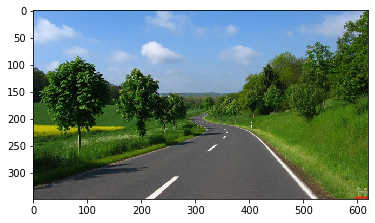

In [3]:
path = "C:\\Users\\LENOVO\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\test2-mini.jpg"
arr = imageio.imread(path)
print ("initial image")
imshow(arr, cmap='gray');
arr.shape

In [4]:
imageio.imread

<function imageio.core.functions.imread(uri, format=None, **kwargs)>

In [5]:
initial_probability = {"C:\\Users\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Sky.jpg": 0.30,"C:\\Users\\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Road.jpg": 0.20, "C:\\Users\\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Grass.jpg":0.50}
number_of_pixels = arr.size
class_info = []
paths= ["C:\\Users\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Sky.jpg", "C:\\Users\\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Road.jpg", "C:\\Users\\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Grass.jpg"]
for path in paths:
    tmp_arr = imageio.imread(path)
    class_mean = np.mean(tmp_arr)
    class_var = np.var(tmp_arr)
    class_freq = len(tmp_arr)
    class_probabilty = class_freq/number_of_pixels
    class_info.append([initial_probability[path], class_mean, class_var])

print ("class_info")
print (class_info)

class_info
[[0.3, 176.85142644226036, 1865.0011904752103], [0.2, 94.96295836413479, 952.7197602171566], [0.5, 47.6763560770979, 1453.6395021370026]]


In [6]:
def pdf_of_normal(x, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

In [7]:
def naive_bayes_predict (arr, class_info, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            val = arr[i][j]
            for cls_index in range(len(class_info)):
                cls_p =  class_info[cls_index][0]
                mean =  class_info[cls_index][1]
                var = class_info[cls_index][2]
                pos =pdf_of_normal(val, mean, var)
                cls_posterior = cls_p * pos

                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index
            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

In [8]:
def distance (x,y):
    a = x-y
    a = a*a
    return np.sqrt(np.sum(a))

In [9]:
def differnce(a,b):
    if (a==b):
        return -1
    else:
        return 1

In [10]:
def initial_energy_function(initial_w, pixels, betha, cls_info, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = cls_info[int (w[i][j])][1]
            var =  cls_info[int (w[i][j])][2]
            energy += np.log(np.sqrt(2*np.pi*var)) 
            energy += ((pixels[i][j]-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * differnce(w[i][j], w[a][b])
    return energy

In [11]:
def exponential_schedule(step_number, current_t, initial_temp,  constant=0.99):
    return current_t*constant
def logarithmical_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_number))
def linear_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_number)

In [12]:
def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])
    
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])

    # print ("END energy", new_energy)

    return new_energy - initial_energy

In [13]:
def simulated_annealing(init_w, class_labels, temprature_function,
                        pixels, betha, cls_info, neighbors_indices, max_iteration=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True

    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function(w, pixels, betha, cls_info, neighbors_indices)
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        delta = delta_enegry(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_info)

        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            # print ("CHANGED better")
        else:
            try:
                if (-delta / current_tmp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0

            if r < k:
                # print("CHANGED worse")
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array

In [14]:
def convert_to_class_labels(arr, inverse_array={0:0, 127:1, 255:2}):
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            arr[i][j] = inverse_array[int(arr[i][j])]

In [15]:
def get_accuracy(arr, labels):
    correct = 0
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            if (labels[i][j]==int(arr[i][j]/127)):
                correct+=1
    return correct/(len(arr[0])*len(arr))


In [16]:
# plt.close('all')
def a_complete_set_for_part_2 (arr, class_info, max_iter=1000000,var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2], 
                               class_color = [0,127,255], 
                               schedule= exponential_schedule,
                               temprature_function_constant=None):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#     fig.suptitle('Comparision', fontsize=20)
    

    ax1.set_title("initial image")

    ax1.imshow(arr, cmap='gray')


    rows = len(arr)
    cols = len(arr[0])

#     cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    cls_info = class_info
    initial_arr = naive_bayes_predict(arr, cls_info)
    ax2.set_title('Naive Bayes image')
    ax2.imshow(initial_arr, cmap='gray')

    convert_to_class_labels(initial_arr)
    
    w, test_array = simulated_annealing(initial_arr, class_labels, schedule,
                                        arr, betha, cls_info, neighbor_indices, max_iteration=max_iter)

    
    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image')
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)
    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

    
    plt.show()


In [17]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1280x1440 with 0 Axes>

<Figure size 1280x1440 with 0 Axes>

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1280x1440 with 0 Axes>

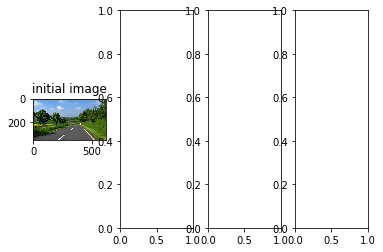

In [18]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')
a_complete_set_for_part_2(arr,class_info, max_iter=1e4, betha=1e4)


In [ ]:
a_complete_set_for_part_2(arr,class_info, max_iter=1e4, betha=1e6)


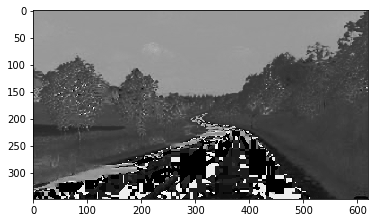

In [28]:
import matplotlib
path = "C:\\Users\\LENOVO\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\test2-mini.jpg"
img = Image.open(path)
hsv_arr = matplotlib.colors.rgb_to_hsv(img)
hsv_arr = np.asarray(hsv_arr)
h_arr = hsv_arr[:,:,0]
plt.imshow(h_arr, cmap="gray")
plt.show()

In [29]:
def read_image_h(path):
    img = Image.open(path)
    hsv_arr = matplotlib.colors.rgb_to_hsv(img)
    hsv_arr = np.asarray(hsv_arr)
    h_arr = hsv_arr[:,:,0]
#     plt.imshow(h_arr, cmap="gray")
#     plt.show()
    return 256*h_arr

In [31]:
initial_probability = {"C:\\Users\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Sky.jpg": 0.30,"C:\\Users\\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Road.jpg": 0.20, "C:\\Users\\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Grass.jpg":0.50}
number_of_pixels = arr.size
class_info = []
paths= ["C:\\Users\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Sky.jpg", "C:\\Users\\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Road.jpg", "C:\\Users\\LENOVO\\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\Grass.jpg"]
for path in paths:
    tmp_arr = read_image_h(path)
    class_mean = np.mean(tmp_arr)
    class_var = np.var(tmp_arr)
    class_freq = len(tmp_arr)
    class_probabilty = class_freq/number_of_pixels
    class_info.append([initial_probability[path], class_mean, class_var])

print ("class_info")
print (class_info)

class_info
[[0.3, 151.39041, 2.6179988], [0.2, 64.93362, 6850.9604], [0.5, 67.78984, 159.66528]]


In [32]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1280x1440 with 0 Axes>

<Figure size 1280x1440 with 0 Axes>

In [33]:
arr_h = read_image_h("C:\\Users\\LENOVO\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\test2-mini.jpg")

FloatingPointError: underflow encountered in exp

<Figure size 1280x1440 with 0 Axes>

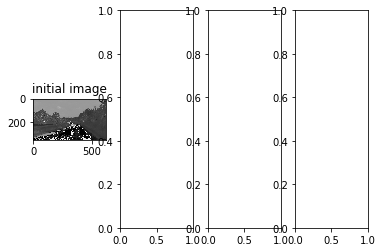

In [34]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e2, betha=1e4)


In [129]:
def get_class_info_color(img_path, color_index,
                         paths=["Sky.jpg", "Road.jpg", "Grass.jpg"],
                         initial_probability={"Sky.jpg": 0.30,"Road.jpg": 0.20, "Grass.jpg":0.50}):
    arr_general = misc.imread(img_path)
    arr = arr_general[:,:,color_index]
    number_of_pixels = arr.size
    class_info = []
    paths= ["Sky.jpg", "Road.jpg", "Grass.jpg"]
    for path in paths:
        tmp_arr = misc.imread(path)
        tmp_arr = tmp_arr[:,:,color_index]
        class_mean = np.mean(tmp_arr)
        class_var = np.var(tmp_arr)
        class_freq = len(tmp_arr)
        # class_probabilty = class_freq/number_of_pixels
        class_info.append([initial_probability[path], class_mean, class_var])

    return class_info

In [130]:
def naive_bayes_predict_3_color (arr, class_infos, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            
            for cls_index in range(0, len(class_color)):
                cls_posterior = class_infos[0][cls_index][0]
                for c in range(0, 3):#for RGB
                    val = arr[i][j][c]
                    class_info = class_infos[c]
                    mean =  class_info[cls_index][1]
                    var = class_info[cls_index][2]
                    pos =pdf_of_normal(val, mean, var)
                    cls_posterior *= pos
                    
                
                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index     

            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

In [131]:
def initial_energy_function_colored(initial_w, pixels, betha, cls_infos, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            for c in [0,1,2]:
                cls_info = cls_infos[c]
                mean = cls_info[int (w[i][j])][1]
                var =  cls_info[int (w[i][j])][2]
                pixel_value = pixels[i][j][c]
                energy += np.log(np.sqrt(2*np.pi*var)) 
                energy += ((pixel_value-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * differnce(w[i][j], w[a][b])
    return energy

In [132]:
def delta_enegry_colored(w, index, betha, new_value, neighbors_indices, pixels, cls_infos):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    for c in [0,1,2]:
        cls_info = cls_infos[c]
        mean = cls_info[int(w[i][j])][1]
        var =  cls_info[int(w[i][j])][2]
        pixel_value = pixels[i][j][c]
        initial_energy += np.log(np.sqrt(2*np.pi*var)) 
        initial_energy += ((pixel_value-mean)**2)/(2*var)
        
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])
    
    new_energy = 0
    for c in [0,1,2]:
        cls_info = cls_infos[c]
        mean = cls_info[new_value][1]
        var =  cls_info[new_value][2]
        pixel_value = pixels[i][j][c]
        new_energy += np.log(np.sqrt(2*np.pi*var)) 
        new_energy += ((pixel_value-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])

    # print ("END energy", new_energy)

    return new_energy - initial_energy

In [133]:
def simulated_annealing_colored(init_w, class_labels, temprature_function,
                        pixels, betha, cls_infos, neighbors_indices, max_iteration=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True
    
    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function_colored(w, pixels, betha, cls_infos, neighbors_indices)
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        delta = delta_enegry_colored(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_infos)

        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            # print ("CHANGED better")
        else:
            try:
                if (-delta / current_tmp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0

            if r < k:
                # print("CHANGED worse")
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array

In [134]:
def a_complete_set_for_part_2_3_color (max_iter=1000000, var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2],
                               class_color = [0,127,255],
                               schedule= exponential_schedule,
                               temprature_function_constant=None,
                               image_path = "C:\\Users\\LENOVO\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\test2-mini.jpg"):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#     fig.suptitle('Comparision', fontsize=20)

    arr = imageio.imread(image_path)
    ax1.set_title("initial image")

    ax1.imshow(arr)




#     cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    cls_infos = []
    for c in [0,1,2]:
        tmp_info =get_class_info_color(image_path,c)
        cls_infos.append(tmp_info)


    initial_arr = naive_bayes_predict_3_color(arr, cls_infos)
    ax2.set_title('Naive Bayes image')
    ax2.imshow(initial_arr, cmap='gray')

    
    convert_to_class_labels(initial_arr)

    w, test_array = simulated_annealing_colored(initial_arr, class_labels, schedule,
                                        arr, betha, cls_infos, neighbor_indices, max_iteration=max_iter)


    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image')
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)
    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

AttributeError: module 'scipy.misc' has no attribute 'imread'

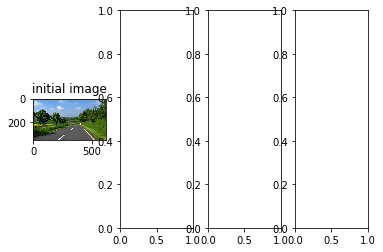

In [135]:
a_complete_set_for_part_2_3_color(max_iter=1e2, betha=1e4)


initial image


(349, 620, 3)

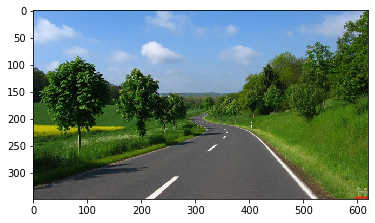

In [40]:
path = "C:\\Users\\LENOVO\Desktop\\AI2.0\\Project_Works_docs\\Markov-Random-Field-Project-master\\test2-mini.jpg"
arr = imageio.imread(path)
print ("initial image")
imshow(arr, cmap='gray');
arr.shape


### Denoising

In [121]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [122]:
def load_image(filename):
    my_img = plt.imread(filename)
    img_gray = np.dot(my_img[..., :3], [0.2989, 0.5870, 0.1140])
    img_gray = np.where(img_gray > 0.5, 1, -1)
    img_padded = np.zeros([img_gray.shape[0] + 2, img_gray.shape[1] + 2])
    img_padded[1:-1, 1:-1] = img_gray
    return img_padded

In [123]:
def sample_y(i, j, Y, X):
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ITA * markov_blanket[-1] + BETA * sum(markov_blanket[:4])
    prob = 1 / (1 + math.exp(-2*w))
    return (np.random.rand() < prob) * 2 - 1

In [124]:

def get_posterior(filename, burn_in_steps, total_samples, logfile):
    X = load_image(filename)
    posterior = np.zeros(X.shape)
    print(X.shape)
    Y = np.random.choice([1, -1], size=X.shape)
    energy_list = list()
    for step in range(burn_in_steps + total_samples):
        for i in range(1, Y.shape[0]-1):
            for j in range(1, Y.shape[1]-1):
                y = sample_y(i, j, Y, X)
                Y[i, j] = y
                if y == 1 and step >= burn_in_steps:
                    posterior[i, j] += 1
        energy = -np.sum(np.multiply(Y, X))*ITA-(np.sum(np.multiply(Y[:-1], Y[1:]))+np.sum(np.multiply(Y[:, :-1], Y[:, 1:])))*BETA
        if step < burn_in_steps:
            energy_list.append(str(step) + "\t" + str(energy) + "\tB")
        else:
            energy_list.append(str(step) + "\t" + str(energy) + "\tS")
    posterior = posterior / total_samples

    file = open(logfile, 'w')
    for element in energy_list:
        file.writelines(element)
        file.write('\n')
    file.close()
    return posterior


In [125]:
def denoise_image(filename, burn_in_steps, total_samples, logfile):
    posterior = get_posterior(filename, burn_in_steps, total_samples, logfile=logfile)
    denoised = np.zeros(posterior.shape, dtype=np.float64)
    denoised[posterior > 0.5] = 1
    return denoised[1:-1, 1:-1]

In [126]:
def plot_energy(filename):
    x = np.genfromtxt(filename, dtype=None, encoding='utf8')
    its, energies, phases = zip(*x)
    its = np.asarray(its)
    energies = np.asarray(energies)
    phases = np.asarray(phases)
    burn_mask = (phases == 'B')
    samp_mask = (phases == 'S')
    assert np.sum(burn_mask) + np.sum(samp_mask) == len(x), 'Found bad phase'
    its_burn, energies_burn = its[burn_mask], energies[burn_mask]
    its_samp, energies_samp = its[samp_mask], energies[samp_mask]
    p1, = plt.plot(its_burn, energies_burn, 'r')
    p2, = plt.plot(its_samp, energies_samp, 'b')
    plt.title("energy")
    plt.xlabel('iteration number')
    plt.ylabel('energy')
    plt.legend([p1, p2], ['burn in', 'sampling'])
    plt.savefig('%s.png' % filename)
    plt.close()


In [127]:
def save_image(denoised_image):
    plt.imshow(denoised_image, cmap='gray')
    plt.title("denoised image")
    plt.savefig('output/denoise_image.png')
   #  plt.savefig("C:\\Users\\LENOVO\\Desktop\\Medium-Tutorials-master\\mcmc_gibbs\\oput\\denoise_image.png")
    plt.close()

In [ ]:
if __name__ == '__main__':
    ITA = 1
    BETA = 1
    total_samples = 1000
    burn_in_steps = 100
    logfile = "output/log_energy"
    denoised_img = denoise_image("C:\\Users\\LENOVO\\Desktop\\eDa\\Medium-Tutorials-master\\mcmc_gibbs\\data\\img_noisy.png", burn_in_steps=burn_in_steps,
                                 total_samples=total_samples, logfile=logfile)
    plot_energy(logfile)
    save_image(denoised_img)

In [58]:
from PIL import Image
import imageio
import numpy as np
import matplotlib.pyplot as plt
import random

In [59]:
COLOR_CLASSES = [0, 127, 255]
CLASSES = [0, 1, 2]
four_neighbors_related_positions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
eight_neighbors_related_positions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]


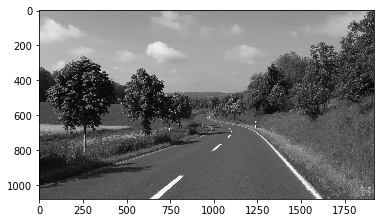

In [60]:
path = "C:\\Users\\LENOVO\\Desktop\\eDa\\mrf-segmentation-denoising-master\\data\\test2.jpg"
image = imageio.imread(path, as_gray=True)
plt.imshow(image, label="gray image", cmap='gray')

In [61]:
def get_class_labels(data: [], mode='gray'):
    labels = np.zeros((len(data), len(data[0])))
    for row in range(len(data)):
        for col in range(len(data[0])):
            value = data[row][col]
            if mode == 'rgb':
                value = value[0] * 0.2125 + value[1] * 0.7154 + value[2] * 0.0721
            if value < 85:
                label = 0
            elif value < 170:
                label = 1
            else:
                label = 2
            labels[row][col] = label

    return labels


def get_class_information(data: [], labels: []):
    data_info = {}
    class_info = {}

    for c in CLASSES:
        data_info[c] = {
            'data': [],
            'mean': 0,
            'var': 0,
            'probability': 0
        }

        class_info[c] = {
            'mean': 0,
            'var': 0,
            'probability': 0
        }

    for c in CLASSES:
        for row in range(len(data)):
            for col in range(len(data[0])):
                if labels[row][col] == c:
                    data_info.get(c).get('data').append(data[row][col])

    data_count = len(data) * len(data[0])
    for c in CLASSES:
        class_info[c] = {
            'mean': np.mean(data_info.get(c).get('data')),
            'var': np.var(data_info.get(c).get('data')),
            'probability': len(data_info.get(c).get('data')) / data_count
        }
    return class_info


true_labels = get_class_labels(data=image)


# Part C
class SimulatedAnnealing:

    def __init__(self, labels, image, class_info, neighbors_related_positions, iterations=1000, temperature=10000,
                 betha=1, schedule_coefficient=1, schedule_steps=1000, mode='gray'):
        self.labels = labels
        self.image = image
        self.class_info = class_info
        self.iterations = iterations
        self.temperature = temperature
        self.neighbors_related_positions = neighbors_related_positions
        self.betha = betha
        self.schedule_coefficient = schedule_coefficient
        self.schedule_steps = schedule_steps
        self.mode = mode

    def move(self, labels):
        new_classes = np.copy(CLASSES).tolist()

        random_index_x, random_index_y = random.randint(0, len(labels) - 1), random.randint(0, len(labels[0]) - 1)
        random_label = random.randint(0, len(new_classes) - 1)

        while labels[random_index_x][random_index_y] == random_label:
            random_label = random.randint(0, len(new_classes) - 1)
        return random_label, random_index_x, random_index_y

    def energy(self, new_labels, label, row, col):
        energy = 0.0
        class_mean = self.class_info[int(label)].get('mean')
        class_var = self.class_info[int(label)].get('var')
        energy += np.log(np.sqrt(2 * np.pi * class_var)) + ((label * 127 - class_mean) ** 2) / (2 * (class_var ** 2))
        neighbors_indexes = self.get_neighbours_indexes(row, col)
        for neighbor in neighbors_indexes:
            if neighbor[0] < len(new_labels) and neighbor[1] < len(new_labels[0]):
                energy += self.betha * self.are_different(label, new_labels[neighbor[0]][neighbor[1]])
        return energy

    
    def anneal(self, temperature_function):
        new_labels = np.copy(self.labels)
        temperature = self.temperature
        for i in range(self.iterations):
            random_label, random_row, random_col = self.move(new_labels)
            current_energy = self.energy(new_labels, new_labels[random_row][random_col], random_row, random_col)
            new_energy = self.energy(new_labels, random_label, random_row, random_col)
            delta_U = new_energy - current_energy
            random_uniform = random.uniform(0, 1)
            if self.is_eligible_to_update(delta_U, temperature, random_uniform):
                new_labels[random_row][random_col] = random_label
            temperature = temperature_function(temperature)
        return new_labels

    def get_neighbours_indexes(self, row, col):
        indexes = []
        for index in self.neighbors_related_positions:
            indexes.append((row + index[0], col + index[1]))

        return indexes

    @staticmethod
    def is_eligible_to_update(delta_U, temperature, random_uniform):
        return delta_U <= 0 or (delta_U > 0 and random_uniform < np.exp(-delta_U / temperature))

    @staticmethod
    def distance(a, b):
        return np.sqrt(np.sum(np.exp(a - b, 2)))

    @staticmethod
    def are_different(x, y):
        if x == y:
            return -1
        return 1

    def exponential_schedule(self, temperature):
        return temperature * 0.99

    def logarithmic_multiplicative_cooling_schedule(self, temperature):
        return temperature / (1 + self.schedule_coefficient * np.log(1 + self.schedule_steps))

    def linear_multiplicative_cooling_schedule(self, temperature):
        return temperature / (1 + self.schedule_coefficient * self.schedule_steps)




In [91]:
def plot_before_after(before, after):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    ax1.set_title('Real image')
    ax1.imshow(before, cmap='gray')

    ax2.set_title('Simulated Annealing')
    ax2.imshow(after, cmap='gray')

    plt.show()

In [68]:
def compare_nb_and_sa(betha=0.1, iterations=1000):
    class_info = get_class_information(image, true_labels)
    simulated_annealer = SimulatedAnnealing(labels=true_labels, image=image, class_info=class_info,
                                            neighbors_related_positions=four_neighbors_related_positions,
                                            iterations=iterations,
                                            betha=betha)

    optimized_labels = simulated_annealer.anneal(simulated_annealer.exponential_schedule)
    plot_before_after(image, optimized_labels)

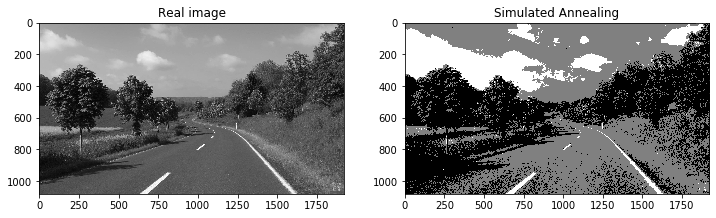

In [69]:
compare_nb_and_sa()

In [49]:
from skimage.color import rgb2hsv

def plot_before_after(before, after, before_label, after_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    ax1.set_title(before_label)
    ax1.imshow(before)

    ax2.set_title(after_label)
    ax2.imshow(after)

    plt.show()

rgb_image = imageio.imread(path)

hsv_image = rgb2hsv(rgb_image)
hue_image = hsv_image[:, :, 0]

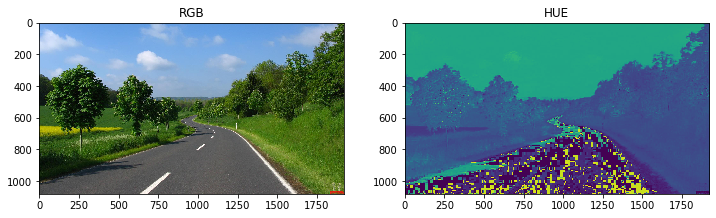

In [50]:
plot_before_after(rgb_image, hue_image, 'RGB', 'HUE')

In [51]:
def plot_before_after(before, after, before_label, after_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    ax1.set_title(before_label)
    ax1.imshow(before, cmap='gray')

    ax2.set_title(after_label)
    ax2.imshow(after, cmap='gray')

    plt.show()

In [85]:
def compare_hue_and_gray(hue_image):
    hue_labels = get_class_labels(data=hue_image*256)
    class_info = get_class_information(image, true_labels)
    simulated_annealer = SimulatedAnnealing(labels=hue_labels, image=hue_image*256, class_info=class_info,
                                            neighbors_related_positions=four_neighbors_related_positions,
                                            iterations=100000,
                                            betha=100)

    hue_labels = simulated_annealer.anneal(simulated_annealer.exponential_schedule)
    plot_before_after(hue_image, hue_labels, 'HUE', 'SA HUE')

In [86]:
compare_hue_and_gray(hue_image)

FloatingPointError: underflow encountered in exp

In [87]:
rgb_image = imageio.imread(path)
rgb_labels = get_class_labels(data=rgb_image, mode='rgb')
class_info = get_class_information(rgb_image, rgb_labels)

In [88]:
def get_rgb_class_labels(data: []):
    labels = np.zeros((len(data), len(data[0])))
    for row in range(len(data)):
        for col in range(len(data[0])):
            value = data[row][col]
            if value[2] > 200:
                label = 1
            elif value[2] < 70:
                label = 2
            else:
                label = 0
            labels[row][col] = label

    return labels


rgb_image = imageio.imread(path)
rgb_labels = get_rgb_class_labels(data=rgb_image)
class_info = get_class_information(rgb_image, rgb_labels)

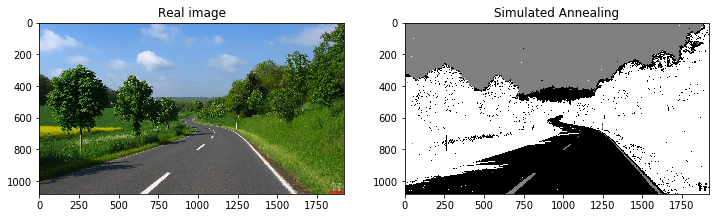

In [90]:
simulated_annealer = SimulatedAnnealing(labels=rgb_labels, image=rgb_image, class_info=class_info,
                                        neighbors_related_positions=eight_neighbors_related_positions,
                                        iterations=1000,
                                        betha=0.1, mode='rgb')

optimized_labels = simulated_annealer.anneal(simulated_annealer.exponential_schedule)
plot_before_after(rgb_image, optimized_labels)